# Notebook para testar a classificacao por clusters

In [152]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

import yara
import yara_tools

In [153]:
TRAIN_DIR = '/archive/files/nastyware-files/import-arquivos-nilson/'
TEST_MALWARE_DIR = '/archive/files/nastyware-files/import-malware-bazaar-2021-01-to-2021-02/'
TEST_GOODWARE_DIR = '/archive/files/nastyware-files/import-windows-server-2016/'

In [154]:
# !./pe-analyser.py --folder $TRAIN_DIR

In [155]:

lines = open('node_clustering.txt', 'r').readlines()
lines = lines[1:]

clusters = [[el.strip() for el in line.strip().split(',') if not el.strip().startswith('-')] for line in lines]

In [156]:
EPSILON = 0.2

In [157]:
mostly_malware_clusters = []

for cluster in clusters:
    if len(cluster) > 1:
        malware_count = 0
        for node in cluster:
            if node.startswith('R-'):
                malware_count += 1

        # Verificar a frequencia com que sera adicionado no cluster
        if malware_count >= EPSILON * len(cluster):
            mostly_malware_clusters.append(cluster)

mostly_malware_clusters

[['R-Gandcrab.sample', 'R-cryptowall.sample', 'R-Locky.sample'],
 ['R-System_Lock_1.2b1.sample',
  'R-Buhtrap.sample',
  'R-Manager.sample',
  'R-Vipasana.sample'],
 ['G-CompMgmtLauncher.exe',
  'R-Dharma.sample',
  'R-Mamba_xox_b.sample',
  'R-Ransomware.tmp.sample',
  'R-Ryuk2.sample',
  'G-atl100.dll',
  'G-mscories.dll',
  'G-msdadiag.dll'],
 ['G-mqmigplugin.dll',
  'G-mscoree.dll',
  'R-Faux-v3.sample',
  'R-131.sample',
  'R-Ryuk_copy.sample'],
 ['R-Avaddon.sample',
  'R-Lockbit.Trojan.sample',
  'R-Ransomware.tmp2.sample',
  'R-Troldesh.sample',
  'R-Djvu.sample'],
 ['G-MRT.exe',
  'G-adal.dll',
  'R-Petya.sample',
  'G-adprep.dll',
  'R-LockBit_14_02_2021.sample',
  'R-Lockbit.sample'],
 ['G-BOOTVID.DLL',
  'G-mcupdate_AuthenticAMD.dll',
  'G-mcupdate_GenuineIntel.dll',
  'R-Satana.sample'],
 ['G-BPAInst.dll',
  'G-MuxInst.dll',
  'G-miguiresource.dll',
  'G-mscat32.dll',
  'G-mssip32.dll',
  'R-File.sample',
  'R-Revil.sample',
  'R-Revil_Sodinokibi.sample'],
 ['R-Crysis.sampl

---

## Primeiro teste - Decision Tree

### Treinando o classificador

In [158]:
func_dict = {}

In [159]:
def ld_data(dir_name, files, label=None):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in files:
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                lib, func = line.split(' ')
                if '@' in func or '?' in func:
                    continue

                if not func.lower() in func_dict:
                    func_dict[func.lower()] = [(lib, func)]
                else:
                    func_dict[func.lower()].append((lib, func))

                funcs.append(func)

        # label = 'MALWARE' if filename.startswith('R') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df

In [160]:
malware_clusters_df = [ld_data(TRAIN_DIR, cluster, str(i)) for i, cluster in enumerate(mostly_malware_clusters)]
rest_df = ld_data(TRAIN_DIR, [f for f in os.listdir(TRAIN_DIR) if not any([f in cluster for cluster in mostly_malware_clusters])], '-1')

# Concat in rest_df all malware_clusters_df
df = pd.concat([rest_df] + malware_clusters_df, ignore_index=True)

In [161]:
df

,filename,label,funcs
0,G-cdp.dll,-1,_initterm_e _initterm _o__localtime64 _o__lock...
1,G-ConnectedAccountState.dll,-1,_unlock __C_specific_handler __dllonexit _amsg...
2,G-MapControlCore.dll,-1,_initterm _initterm_e _o__purecall _o__registe...
3,G-amsiproxy.dll,-1,__C_specific_handler malloc free _amsg_exit _i...
4,G-MDEServer.exe,-1,_wcsnicmp _unlock _lock _commode _fmode wcsncm...
...,...,...,...
783,R-Ransomware.sample,9,WriteFile WriteConsoleW WaitForMultipleObjects...
784,R-RedBoot.sample,9,LoadLibraryA GetProcAddress VirtualProtect Vir...
785,R-Buran.sample,10,GetProcAddress GetVersion LoadLibraryA Virtual...
786,R-MSSECSVC.sample,10,WaitForSingleObject InterlockedIncrement GetCu...


In [162]:
# Mudar isso para um BAG OF WORDS
vectorizer = TfidfVectorizer()
df_vectors = vectorizer.fit_transform(df['funcs']).ceil()

classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(df_vectors, df['label'])

DecisionTreeClassifier(criterion='entropy')

/home/joao/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


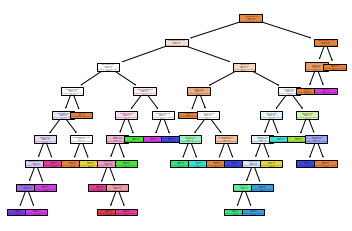

In [163]:
fn = vectorizer.get_feature_names()
cn = df['label'].unique()

plot_tree(classifier,
               feature_names = fn,
               class_names=cn,
               filled = True);

plt.savefig('asdf.svg')

### Testando o classificador

In [164]:
test_mw = ld_data(TEST_MALWARE_DIR, os.listdir(TEST_MALWARE_DIR), 'MALWARE')
test_gw = ld_data(TEST_GOODWARE_DIR, os.listdir(TEST_GOODWARE_DIR), 'GOODWARE')

test_df = pd.concat([test_mw, test_gw], ignore_index=True)

In [165]:
test_mw_vectors = vectorizer.transform(test_mw['funcs']).ceil()
test_gw_vectors = vectorizer.transform(test_gw['funcs']).ceil()
test_vectors = vectorizer.transform(test_df['funcs']).ceil()

pred_mw = classifier.predict(test_mw_vectors)
pred_gw = classifier.predict(test_gw_vectors)
pred = classifier.predict(test_vectors)

pred_mw = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred_mw]
pred_gw = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred_gw]
pred = ['MALWARE' if p != '-1' else 'GOODWARE' for p in pred]

In [166]:
print('Accuracy total: {}'.format(accuracy_score(test_df['label'], pred)))
print('Accuracy malware: {}'.format(accuracy_score(test_mw['label'], pred_mw)))
print('Accuracy goodware: {}'.format(accuracy_score(test_gw['label'], pred_gw)))
print('F1 score: {}'.format(f1_score(test_df['label'], pred, average='weighted')))

Accuracy total: 0.7029625623460128
Accuracy malware: 0.9559841740850643
Accuracy goodware: 0.46369694843914416
F1 score: 0.6849486465364006


### Criando regras YARA

In [167]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold
value = classifier.tree_.value
impurity = classifier.tree_.impurity

In [168]:
def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] != -1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] != -1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False

def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        if index != len(path) - 1:
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

def get_yara_rule(rule, condition_group, path, column_names):
    for index, node in enumerate(path):
        if index != len(path) - 1:
            func_lwr = column_names[feature[node]]
            if (children_left[node] == path[index+1]):
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="and")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'not(pe.imports("{lib}", "{func}"))', condition_group="{}_{}".format(condition_group, index))
            else:
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="or")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'pe.imports("{lib}", "{func}")', condition_group="{}_{}".format(condition_group, index))

In [172]:
for i in range(len(df['label'].unique()) - 1):

    rule = yara_tools.create_rule(name=f"rule_cluster_{i}", default_boolean='or')

    rule.add_import(name="pe")

    # Leaves
    leave_id = classifier.apply(df_vectors)

    paths = {}
    for leaf in np.unique(leave_id):
        path_leaf = []
        find_path(0, path_leaf, leaf)
        paths[leaf] = np.unique(np.sort(path_leaf))

    # Cut paths that lead to goodwares
    filtered_paths = {}
    for path in paths:
        samples_count = value[path][0]
        goodware_value_index = 0
        malware_value_index = i + 1
        if samples_count[malware_value_index] > samples_count[goodware_value_index]:
            filtered_paths[path] = paths[path]

    paths = filtered_paths

    for leaf_num in paths:
        rule.create_condition_group(name="group_{}".format(leaf_num), default_boolean='and')
        get_yara_rule(rule, "group_{}".format(leaf_num), paths[leaf_num], vectorizer.get_feature_names_out())

    generated_rule = rule.build_rule(condition_groups=True)

    compiled_rule = yara.compile(source=generated_rule)

    print (generated_rule)


import "pe"

rule rule_cluster_0
{


	condition:
		((not(pe.imports("msvcrt.dll", "__C_specific_handler")) and not(pe.imports("api-ms-win-crt-private-l1-1-0.dll", "__C_specific_handler")) and not(pe.imports("vcruntime140.dll", "__C_specific_handler")) and not(pe.imports("msvcr120_clr0400.dll", "__C_specific_handler")) and not(pe.imports("ntdll.dll", "__C_specific_handler")) and not(pe.imports("api-ms-win-core-crt-l1-1-0.dll", "__C_specific_handler")) and not(pe.imports("msvcr120.dll", "__C_specific_handler")) and not(pe.imports("msvcr100.dll", "__C_specific_handler")) and not(pe.imports("win32k.sys", "__C_specific_handler")) and not(pe.imports("ntoskrnl.exe", "__C_specific_handler")) and not(pe.imports("kernel32.dll", "__C_specific_handler")) and not(pe.imports("msvcr90.dll", "__C_specific_handler")) and not(pe.imports("securekernel.exe", "__C_specific_handler"))) and (not(pe.imports("kernel32.dll", "UnhandledExceptionFilter")) and not(pe.imports("api-ms-win-core-errorhandling-l1-1-1.d

---

## Segundo teste - Similaridades e diferencas

### Obtendo as similaridades e diferencas

In [142]:
# Functions that occur in all malwares in the cluster
def plus_functions(dir, cluster):
    file_sets = []

    for file in cluster:
        file_sets.append(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))
    
    intersection = set.intersection(*file_sets)

    return intersection


# Functions that does not occur in any malwares in the cluster
def minus_functions(dir, cluster):
    others_set = set()

    dir = os.path.join(dir)

    for file in os.listdir(dir):
        if file in cluster:
            continue

        others_set.update(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))
    
    cluster_set = set()
    for file in cluster:
        cluster_set.update(set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()))

    others_minus_cluster = others_set - cluster_set

    return others_minus_cluster

def functions(dir):
    return [set(line.split(' ')[1] for line in open(os.path.join(dir, file)).read().splitlines()) for file in os.listdir(dir)]

In [143]:

plus = [plus_functions(TRAIN_DIR, cluster) for cluster in mostly_malware_clusters]
minus = [minus_functions(TRAIN_DIR, cluster) for cluster in mostly_malware_clusters]

In [144]:
[len(p) for p in plus]

[6, 39, 32, 54, 49, 16, 0, 0, 0, 5, 1, 214]

In [145]:
[len(m) for m in minus]

[11227,
 11323,
 11443,
 11371,
 11425,
 10822,
 11596,
 11590,
 11597,
 11572,
 11421,
 10768]

In [146]:
def predict_similarity_difference(file_functions_set, plus_functions_set_list, minus_functions_set_list):

    for plus_functions_set, minus_functions_set in zip(plus_functions_set_list, minus_functions_set_list):
        plus_functions_intersection = file_functions_set & plus_functions_set
        minus_functions_intersection = file_functions_set & minus_functions_set

        if len(plus_functions_intersection) == len(plus_functions_set) and len(minus_functions_intersection) == 0:
            return 'MALWARE'

    return 'GOODWARE'


In [147]:
test_mw = functions(TEST_MALWARE_DIR)
test_gw = functions(TEST_GOODWARE_DIR)
test = test_mw + test_gw

test_mw_label = ['MALWARE' for _ in test_mw]
test_gw_label = ['GOODWARE' for _ in test_gw]
test_label = test_mw_label + test_gw_label

pred_mw = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test_mw]
pred_gw = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test_gw]
pred = [predict_similarity_difference(file_functions_set, plus, minus) for file_functions_set in test]

In [148]:
print('Accuracy total: {}'.format(accuracy_score(test_label, pred)))
print('Accuracy malware: {}'.format(accuracy_score(test_mw_label, pred_mw)))
print('Accuracy goodware: {}'.format(accuracy_score(test_gw_label, pred_gw)))
print('F1 score: {}'.format(f1_score(test_label, pred, average='weighted')))

Accuracy total: 0.5662520281233099
Accuracy malware: 0.5382047477744807
Accuracy goodware: 0.5927744650999649
F1 score: 0.5659684940215779


### Criando reegras YARA

In [ ]:
if len(plus_functions) != len(minus_functions):
    raise ValueError("Plus and minus functions must be of the same length")

for i in range(len(plus_functions)):
    rule = yara_tools.create_rule(name="rule_cluster_{i}")
    rule.add_import(name="pe")

    # Adicionar o parse com "or" para todas as libs em uma funcao. Talvez usar "groups"